In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from OceanLab import EOF,DYN
import seawater as sw

In [2]:
z = Symbol('z')
g,rho0 = 10,1025

In [38]:
rho = tanh(1e-2*z-3)+rho0
n2 = (g/rho0)*Derivative(rho,z).doit()
rho

tanh(0.01*z - 3) + 1025

## Vertical Modes

In [18]:
zi = np.arange(1000)
rhoi = lambdify(z,rho)(zi)
n2i = lambdify(z,n2)(zi)

nm = 3
Si,radii,Fi = DYN.eqmodes(n2i,-zi,nm,lat=-2,pmodes=True)
Fi2,radii2 = DYN.vmodes(n2i,-zi,nm,lat=-30)

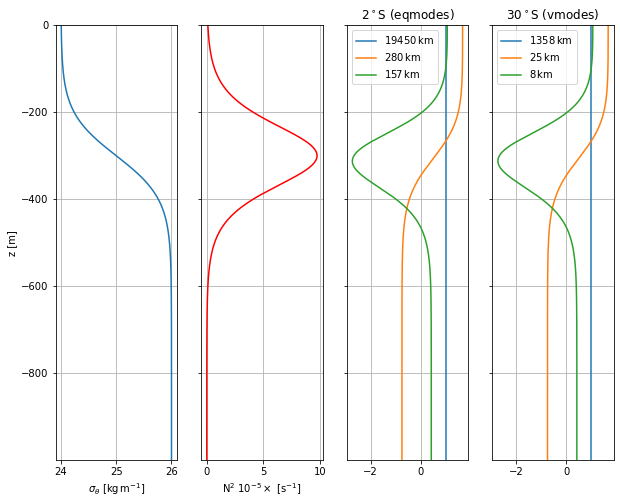

In [194]:
fig,ax = plt.subplots(1,4,figsize=(10,8))

ax[0].plot(rhoi-1000,-zi)
ax[1].plot(n2i*1e5,-zi,'r')

for i in range(nm):
    ax[2].plot(Fi[:,i],-zi,label='{:.0f}$\,$km'.format(radii[i]))
    ax[3].plot(Fi2[:,i],-zi,label='{:.0f}$\,$km'.format(radii2[i]))

ax[2].legend()
ax[3].legend()


ax[0].set(ylabel='z [m]',xlabel='$\sigma_\\theta$ [kg$\,$m$^{-1}$]')
ax[1].set(xlabel='N$^2$ 10$^{-5}\\times$ [s$^{-1}$]')
ax[2].set(title='2$^\circ$S (eqmodes)')
ax[3].set(title='30$^\circ$S (vmodes)')

_ = [a.set(yticklabels=[]) for a in ax[1:]]
_ = [a.grid(True) for a in ax]
_ = [a.set(ylim=[(-zi).min(),(-zi).max()]) for a in ax]

## EOF

Creating a synthetic currentmeter mooring using the vertical modes:

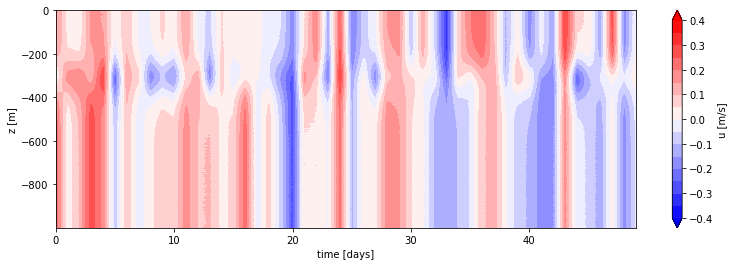

In [195]:
n = 50
ti = np.arange(n)

np.random.seed(0)
ampe = np.array([10,5,3])
amp = np.random.randn(nm,n)*ampe[:,None]
noise = np.random.randn(zi.size,n)/1000

mooring = np.dot(Fi,amp)/100+noise

dl = 0.05
kw = {
    'vmin':-0.4,
    'vmax':0.4,
    'levels':np.arange(-0.4,0.4+dl,dl),
    'cmap':'bwr',
    'extend':'both',
}

fig,ax = plt.subplots(figsize=(13,4))
C = ax.contourf(ti,-zi,mooring,**kw)
ax.set(xlabel='time [days]',ylabel='z [m]')
cbar = fig.colorbar(C)
cbar.set_label('u [m/s]')

In [107]:
evals_perc,evecs_norm,amp = EOF.eoft(mooring)

/home/isimoesdesousa/programs/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/isimoesdesousa/programs/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/isimoesdesousa/programs/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


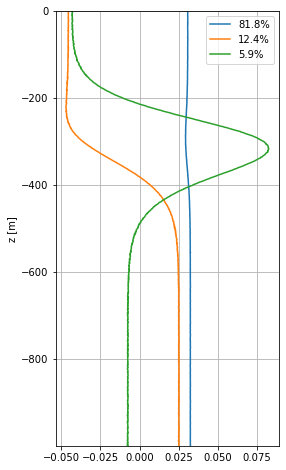

In [196]:
fig,ax = plt.subplots(figsize=(4,8))
for i in range(nm):
    ax.plot(evecs_norm[:,i],-zi,label='{:.1f}%'.format(100*abs(evals_perc[i])))
    
ax.legend()
ax.grid(True)
_ = ax.set(ylabel='z [m]',ylim=[(-zi).min(),(-zi).max()])

Note that, despite being similar, statistical modes (EOFs) must not be confused with pressure vertical modes (QG/Equatorial), and in each EOF we may have variance from different vertical modes.

## zeta

In [282]:
x = Symbol('x')
y = Symbol('y')

ly,lx = 10,10
u = cos(2*pi*y/ly)
v = cos(2*pi*x/lx)

vort = (Derivative(v,x).doit()-Derivative(u,y).doit())/112e3
vort

-1.78571428571429e-6*pi*sin(pi*x/5) + 1.78571428571429e-6*pi*sin(pi*y/5)

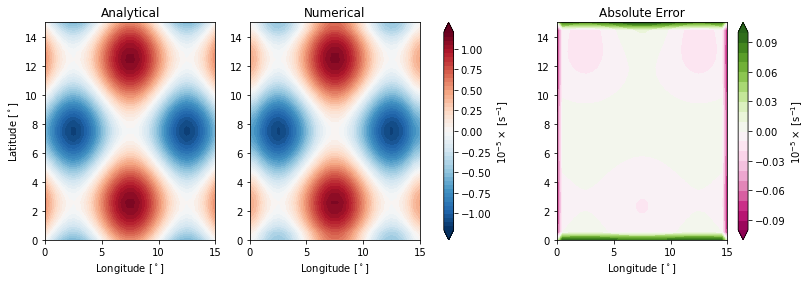

In [284]:
q = 100
xi,yi = np.meshgrid(np.linspace(0,15,q),np.linspace(0,15,q))

vorti = DYN.zeta(xi,yi,lambdify((x,y),u)(xi,yi),lambdify((x,y),v)(xi,yi))


kw = {
    'zeta':{
        'vmin':-1.2,
        'vmax':1.2,
        'levels':np.arange(-1.2,1.2+0.05,0.05),
        'cmap':'RdBu_r',
        'extend':'both',
    },
    'error':{
        'vmin':-0.1,
        'vmax':0.1,
        'levels':np.arange(-0.1,0.1+0.01,0.01),
        'cmap':'PiYG',
        'extend':'both',
    },
}

fig,ax = plt.subplots(1,3,figsize=(13,4))
C = ax[0].contourf(xi,yi,1e5*lambdify((x,y),vort)(xi,yi),**kw['zeta'])
ax[1].contourf(xi,yi,1e5*vorti,**kw['zeta'])
cbar = fig.colorbar(C,ax=ax[:2])
cbar.set_label('10$^{-5}\\times$ [s$^{-1}$]')

C = ax[2].contourf(xi,yi,1e5*(vorti-lambdify((x,y),vort)(xi,yi)),**kw['error'])
cbar = fig.colorbar(C,ax=ax[-1])
cbar.set_label('10$^{-5}\\times$ [s$^{-1}$]')

ax[0].set(title='Analytical')
ax[1].set(title='Numerical')
ax[2].set(title='Absolute Error')


_ = ax[0].set(ylabel='Latitude [$^\circ$]')
_ = [a.set(xlabel='Longitude [$^\circ$]') for a in ax]

## psi2uv

In [259]:
x = Symbol('x')
y = Symbol('y')

amp = 2e5
L = 20
psi = amp*sin(2*pi*x/L)*sin(2*pi*y/(0.5*L))

u = -Derivative(psi,y).doit()/112e3
v = Derivative(psi,x).doit()/112e3

psi

200000.0*sin(pi*x/10)*sin(0.2*pi*y)

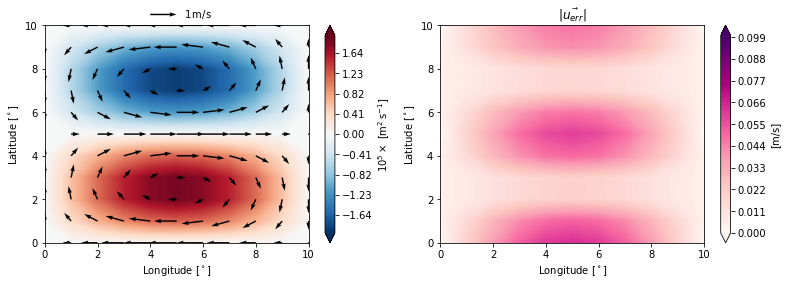

In [280]:
xi,yi = np.mgrid[0:11,0:11]

ui,vi = DYN.psi2uv(xi,yi,lambdify((x,y),psi)(xi,yi))
err = np.sqrt((ui-lambdify((x,y),u)(xi,yi))**2+(vi-lambdify((x,y),v)(xi,yi))**2)

kw = {
    'psi':{
        'vmin':-2,
        'vmax':2,
        'levels':np.arange(-2,2+0.01,0.01),
        'cmap':'RdBu_r',
        'extend':'both',
    },
    'error':{
        'vmin':0,
        'vmax':1e-1,
        'levels':np.arange(0,1e-1+1e-3,1e-3),
        'cmap':'RdPu',
        'extend':'both',
    },
    'quiver':{
        'scale':10,
    },
}

fig,ax = plt.subplots(1,2,figsize=(13,4))
C = ax[0].contourf(xi,yi,1e-5*lambdify((x,y),psi)(xi,yi),**kw['psi'])
Q = ax[0].quiver(xi,yi,ui,vi,**kw['quiver'])
ax[0].quiverkey(Q,0.5,1.05,1,'1$\,$m/s',labelpos='E')
cbar = fig.colorbar(C,ax=ax[0])
cbar.set_label('10$^{5}\\times$ [m$^2\,$s$^{-1}$]')

C = ax[1].contourf(xi,yi,err,**kw['error'])
cbar = fig.colorbar(C,ax=ax[-1])
cbar.set_label('[m/s]')

_ = ax[0].set(xlabel='Longitude [$^\circ$]',ylabel='Latitude [$^\circ$]')
_ = ax[1].set(xlabel='Longitude [$^\circ$]',ylabel='Latitude [$^\circ$]',title='|$\\vec{u_{err}}$|')